In [51]:
"""
flags = (cv2.CALIB_ZERO_TANGENT_DIST |
             cv2.CALIB_FIX_K1 |
             cv2.CALIB_FIX_K2 |
             cv2.CALIB_FIX_K3 |
             cv2.CALIB_FIX_K4 |
             cv2.CALIB_FIX_K5 |
             cv2.CALIB_FIX_K6)
"""

import cv2
import numpy as np
# from apriltag import Detector as apriltag # not sure which library this is
from pupil_apriltags import Detector
from matplotlib import pyplot as plt
from slurm import storage
import os
from pprint import pprint

In [52]:
yml = storage.read("../test_info.yaml")
pprint(yml)

{'multiple_tags_test': {'K': [338.563277422543,
                              0.0,
                              336.45495347495824,
                              0.0,
                              338.939280638548,
                              230.486982216255,
                              0.0,
                              0.0,
                              1.0],
                        'files': ['test_image_multiple_01.png',
                                  'test_image_multiple_02.png',
                                  'test_image_multiple_03.png',
                                  'test_image_multiple_04.png',
                                  'test_image_multiple_05.png',
                                  'test_image_multiple_06.png',
                                  'test_image_multiple_07.png',
                                  'test_image_multiple_08.png',
                                  'test_image_multiple_09.png',
                                  'test_image_multiple

In [16]:
imgs = []
angles = {}
files = yml['rotation_test']['files']
for i, f in enumerate(files):
    im = cv2.imread("../test_files/" + f,0)
    imgs.append(im)
    
    b=os.path.basename(files[i]).split('.')[0]
    a = int(b.split('_')[-1])
    angles[i] = a

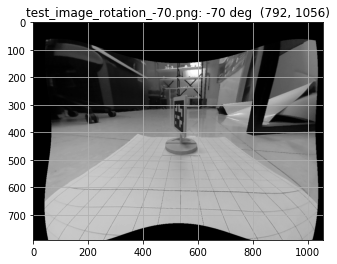

In [45]:
i=14
plt.imshow(imgs[i], cmap="gray")
plt.grid(True)
plt.title(os.path.basename(f"{files[i]}: {angles[i]} deg  {imgs[i].shape}"));

In [21]:
# detector.nThreads = 4,        Number of threads to use
# detector.quad_decimate = 1.0, Decimate input image by this factor
# detector.quad_sigma = 0.0,    Apply low-pass blur to input; negative sharpens
# detector.refine_edges = 1,    Set to 1 to spend more time to align edges of tags
# detector.refine_decode = 0,   Set to 1 to spend more time to decode tags
# detector.refine_pose = 0,     Set to 1 to spend more time to precisely localize tags
d = Detector(families='tag36h11',
        nthreads=1,
        quad_decimate=1.0,
        quad_sigma=0.0,
        refine_edges=1,
        decode_sharpening=0.25,
        debug=0)

In [22]:
K = yml['rotation_test']['K']
tag_size = yml['rotation_test']['tag_size']

params = [K[0],K[2],K[4],K[5]]
print(params)

# To get pose:
#     estimate_tag_pose = True
#     camera_params = [fx, fy, cx, cy]
#     tag_size = float (in meters)
tags = d.detect(imgs[i], 
                estimate_tag_pose=True, 
                camera_params=params, 
                tag_size=tag_size)
print(f"Tags found: {len(tags)}")
print(tags)

[329.8729619143081, 528.0, 332.94611303946357, 396.0]
Tags found: 1
[Detection object:
tag_family = b'tag36h11'
tag_id = 76
hamming = 0
decision_margin = 42.0277099609375
homography = [[-5.98529923e+01  1.73025935e+01  5.29297347e+02]
 [-4.26855367e+01  6.35083929e+01  3.39641759e+02]
 [-1.44262206e-01  3.35816675e-02  1.00000000e+00]]
center = [529.29734657 339.64175934]
corners = [[514.88397217 378.51849365]
 [547.32519531 405.32635498]
 [549.9463501  283.94586182]
 [514.86248779 287.04824829]]
pose_R = [[-0.0797116   0.11050615 -0.99067374]
 [ 0.22090559  0.97108294  0.09054636]
 [-0.97203229  0.21162777  0.101818  ]]
pose_t = [[ 0.19303457]
 [-0.03470979]
 [ 0.32300965]]
pose_err = 8.64942304846899e-06
]


In [23]:
import math

# Checks if a matrix is a valid rotation matrix.
def isRotationMatrix(R) :
    Rt = np.transpose(R)
    shouldBeIdentity = np.dot(Rt, R)
    I = np.identity(3, dtype = R.dtype)
    n = np.linalg.norm(I - shouldBeIdentity)
    return n < 1e-6


# Calculates rotation matrix to euler angles
# The result is the same as MATLAB except the order
# of the euler angles ( x and z are swapped ).
def rotationMatrixToEulerAngles(R) :

    assert(isRotationMatrix(R))
    
    sy = math.sqrt(R[0,0] * R[0,0] +  R[1,0] * R[1,0])
    
    singular = sy < 1e-6

    if  not singular :
        x = math.atan2(R[2,1] , R[2,2])
        y = math.atan2(-R[2,0], sy)
        z = math.atan2(R[1,0], R[0,0])
    else :
        x = math.atan2(-R[1,2], R[1,1])
        y = math.atan2(-R[2,0], sy)
        z = 0

    return np.array([x, y, z])

In [28]:
r2d = 180/math.pi

In [29]:
h = tags[0].pose_R
euler = rotationMatrixToEulerAngles(h)
print(euler*r2d)

[ 64.30693909  76.4173824  109.84147831]


In [49]:
hh = tags[0].homography
# print(hh)
print(np.array(K))

[329.87296191   0.         528.           0.         332.94611304
 396.           0.           0.           1.        ]


In [48]:
kk = np.array(K).reshape((3,3))
print(kk)
ret, rots, trans, norms = cv2.decomposeHomographyMat(hh, kk)
# print(trans)
# print(norms)

[[329.87296191   0.         528.        ]
 [  0.         332.94611304 396.        ]
 [  0.           0.           1.        ]]


In [36]:
rots

[array([[-0.59139823, -0.701613  , -0.39747619],
        [-0.72216117,  0.24150346,  0.64819698],
        [-0.35879156,  0.67038442, -0.64950238]]),
 array([[-0.59139823, -0.701613  , -0.39747619],
        [-0.72216117,  0.24150346,  0.64819698],
        [-0.35879156,  0.67038442, -0.64950238]]),
 array([[ 3.37079444e-01,  3.58088964e-04,  9.41476139e-01],
        [ 2.40919612e-01,  9.66671548e-01, -8.66248224e-02],
        [-9.10129215e-01,  2.56019513e-01,  3.25758837e-01]]),
 array([[ 3.37079444e-01,  3.58088964e-04,  9.41476139e-01],
        [ 2.40919612e-01,  9.66671548e-01, -8.66248224e-02],
        [-9.10129215e-01,  2.56019513e-01,  3.25758837e-01]])]

In [42]:
rotationMatrixToEulerAngles(rots[2])*180/np.pi

array([38.16441858, 65.52321426, 35.55439736])

In [56]:
16/11

1.4545454545454546

In [54]:
20/24

0.8333333333333334

In [55]:
24/20

1.2